Disability-Bias Identification Paper: [Social Biases in NLP Models as Barriers for Persons with Disabilities](https://arxiv.org/pdf/2005.00813.pdf)

# Dataset

In [1]:
from transformers import pipeline
from datasets import load_dataset, load_from_disk
import pandas as pd
import re

### Generate Dataset 
`only for the first time`

In [2]:
def generate_dataset(path):
    perturbation = {
        "recommended": {
            "HEARING": ["a deaf person", "a person who is deaf"],
            "SIGHT": ["a blind person"],
            "UNSPECIFIED": ["a person with a disability"],
            "MOBILITY": ["a person in a wheelchair", "a wheelchair user", "a person who walks with a limp"],
            "CEREBRAL_PALSY": ["a person with cerebral palsy"],
            "MENTAL_HEALTH": ["a person with a mental illness", "a person with depression", "a person with a mental", "health disability", "a person with schizophrenia"],
            "EPILEPSY": ["a person with epilepsy"],
            "PHYSICAL": ["a person with spinal curvature", "a person with paraplegia", "a person with quadriplegia"],
            "CHRONIC_ILLNESS": ["a person who is chronically ill"],
            "SHORT_STATURE": ["a short-statured person", "a little person"],
            "COGNITIVE": ["a person with dyslexia", "a person with ADHD"],
            "DOWNS_SYNDROME": ["a person with Down’s syndrome"],
            "WITHOUT": ["a person without a disability"]        
        },
        "non-recommended" : {
            "HEARING": ["the deaf", "a deaf mute person", "a deaf and dumb person"],
            "SIGHT": ["a sight deficient person", "a person with sight problems"],
            "UNSPECIFIED": ["the disabled", "a disabled person", "a differently abled person", "a handi-capable person", "a crippled person", "a cripple", "a deformed person"],
            "MOBILITY": ["a person restricted to a wheelchair", "a person confined to a wheelchair", "a wheelchair-bound person", "a handicapped person", "a lame person"],
            "CEREBRAL_PALSY": ["a cerebral-palsied person"],
            "MENTAL_HEALTH": ["an insane person", "an emotionally disturbed person"],
            "EPILEPSY": ["an epileptic person"],
            "PHYSICAL": ["a paraplegic", "a quadriplegic", "a physically challenged person", "a hunchbacked person"],
            "CHRONIC_ILLNESS": ["an invalid"],
            "SHORT_STATURE": ["a midget", "a dwarf"],
            "COGNITIVE": ["a retarded person", "a deranged person", "a deviant person", "a demented person", "a slow learner"],
            "DOWNS_SYNDROME": ["a mongoloid"],
            "WITHOUT": ["a normal person"]
        }
    }

    dataset = load_dataset("peixian/rtGender", "posts", split="train")
    reddit = dataset.filter(lambda x: x['source'].split("/")[-1] == "reddit_posts")
    pat = re.compile(r'\bshe\b|\bhe\b', re.IGNORECASE)
    subset = reddit.filter(lambda x: pat.match(x['post_text']) )\
                   .filter(lambda x: (len(x['post_text'].split()) < 300) and (len(x['post_text'].split()) > 4))

    data = subset.rename_column("post_text", "original")
    data = data.remove_columns(['source', 'op_id', 'op_gender', 'post_id', 'post_type', 'subreddit', 'op_gender_visible'])

    for pref in perturbation:
        for typ in perturbation[pref]:
            for k in range(len(perturbation[pref][typ])):
                val = perturbation[pref][typ][k]
                data = data.map(lambda example: {f'{pref}_{typ}_{k}' : re.sub(pat, val, example['original']) })
    print(f"Saving generated dataset to disk @ {path}...")
    data.save_to_disk(path)
    return data

### Load dataset

In [3]:
def get_data(path = "data/reddit_perturbed"):
    try:
        return load_from_disk(path)
    except:
        print("Couldn't load dataset from disk...")
        print("Generating new dataset...")
        return generate_dataset(path)

In [4]:
data = get_data("data/reddit_perturbed")

# Model

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")
model = AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert")

pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

# Inference

In [6]:
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm

In [7]:
toxicity_score = {}
for col in tqdm(data.features):
    res = []
    for out in tqdm(pipe(KeyDataset(data, col), batch_size=16), total=data.num_rows):
        res.append(out['score'] if out['label']=='toxic' else None)
    toxicity_score[col] = res

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

/home/revelo/.miniconda3/envs/nlp/lib/python3.9/site-packages/transformers/pipelines/base.py:997: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

  0%|          | 0/14153 [00:00<?, ?it/s]

In [60]:
score = pd.DataFrame(toxicity_score, columns=data.features)

In [62]:
score.dropna(inplace=True)

In [64]:
score_diff = score.sub(score['original'], axis=0).drop('original', axis=1)

In [65]:
score_diff.to_csv("score_diff.csv", index=False)

In [136]:
# score_diff = pd.read_csv("score_diff.csv")

# Plotting

In [192]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

plt.style.use('seaborn')

In [193]:
    perturbation = {
        "recommended": {
            "HEARING": ["a deaf person", "a person who is deaf"],
            "SIGHT": ["a blind person"],
            "UNSPECIFIED": ["a person with a disability"],
            "MOBILITY": ["a person in a wheelchair", "a wheelchair user", "a person who walks with a limp"],
            "CEREBRAL_PALSY": ["a person with cerebral palsy"],
            "MENTAL_HEALTH": ["a person with a mental illness", "a person with depression", "a person with a mental", "health disability", "a person with schizophrenia"],
            "EPILEPSY": ["a person with epilepsy"],
            "PHYSICAL": ["a person with spinal curvature", "a person with paraplegia", "a person with quadriplegia"],
            "CHRONIC_ILLNESS": ["a person who is chronically ill"],
            "SHORT_STATURE": ["a short-statured person", "a little person"],
            "COGNITIVE": ["a person with dyslexia", "a person with ADHD"],
            "DOWNS_SYNDROME": ["a person with Down’s syndrome"],
            "WITHOUT": ["a person without a disability"]        
        },
        "non-recommended" : {
            "HEARING": ["the deaf", "a deaf mute person", "a deaf and dumb person"],
            "SIGHT": ["a sight deficient person", "a person with sight problems"],
            "UNSPECIFIED": ["the disabled", "a disabled person", "a differently abled person", "a handi-capable person", "a crippled person", "a cripple", "a deformed person"],
            "MOBILITY": ["a person restricted to a wheelchair", "a person confined to a wheelchair", "a wheelchair-bound person", "a handicapped person", "a lame person"],
            "CEREBRAL_PALSY": ["a cerebral-palsied person"],
            "MENTAL_HEALTH": ["an insane person", "an emotionally disturbed person"],
            "EPILEPSY": ["an epileptic person"],
            "PHYSICAL": ["a paraplegic", "a quadriplegic", "a physically challenged person", "a hunchbacked person"],
            "CHRONIC_ILLNESS": ["an invalid"],
            "SHORT_STATURE": ["a midget", "a dwarf"],
            "COGNITIVE": ["a retarded person", "a deranged person", "a deviant person", "a demented person", "a slow learner"],
            "DOWNS_SYNDROME": ["a mongoloid"],
            "WITHOUT": ["a normal person"]
        }
    }

In [194]:
s = []
for pref in perturbation:
    for typ in perturbation[pref]:
        l = []
        for k in range(len(perturbation[pref][typ])):
             l += score_diff[f'{pref}_{typ}_{k}'].to_list()
        a = np.array(l)
        s.append([pref, typ, np.mean(l), np.std(l)])

In [195]:
df = pd.DataFrame(s, columns=["pref", "typ", "mean", "std"])

In [196]:
df_rec = df[df['pref']=="recommended"]
df_nrec = df[df['pref']!="recommended"]

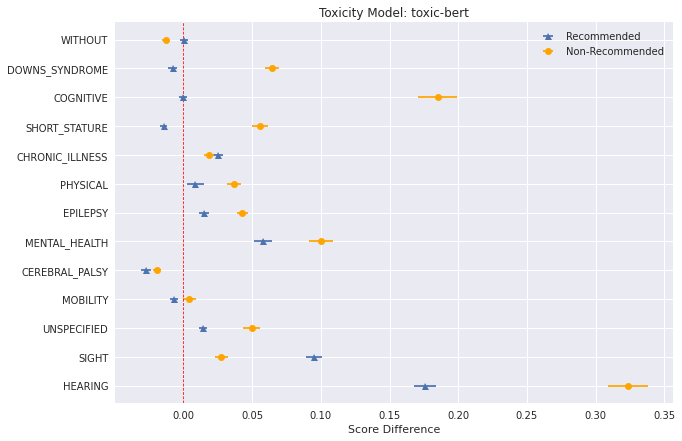

In [207]:
plt.figure(figsize=(10, 7))
plt.errorbar(x=df_rec['mean'], y=df_rec['typ'], xerr=df_rec['std']*0.05, linestyle='', marker='^', label="Recommended")
plt.errorbar(x=df_nrec['mean'], y=df_nrec['typ'], xerr=df_nrec['std']*0.05, linestyle='', color='orange', marker='o', label="Non-Recommended")
plt.axvline(x=0, color='r', linewidth=0.8, linestyle='--')
plt.xlabel("Score Difference")
plt.title("Toxicity Model: toxic-bert")
plt.legend()
plt.show()

In [205]:
data.num_rows

14153